In [70]:
import json
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from google import genai
from google.genai import types

chrome_opts = Options()
chrome_opts.add_argument("--start-maximized")

driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=chrome_opts,
    )
wait = WebDriverWait(driver, 20)
driver.get("https://www.google.com/recaptcha/api2/demo")

In [56]:
# ---------- 1. 勾選「我不是機器人」 ----------
def click_recaptcha_checkbox(driver, wait):
    """
    進入 anchor iframe → 勾選核取框 → 回到主頁。
    """
    anchor_iframe = wait.until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "iframe[src*='anchor']"))
    )
    driver.switch_to.frame(anchor_iframe)

    wait.until(EC.element_to_be_clickable((By.ID, "recaptcha-anchor"))).click()
    print("✅ 已勾選『我不是機器人』")

    driver.switch_to.default_content()        # 切回主頁




In [71]:
click_recaptcha_checkbox(driver, wait)

✅ 已勾選『我不是機器人』


In [ ]:
# ---------- 2.截圖 ----------
def capture_bframe_png(driver, wait, outfile="ocr.png"):
    """切入 bframe → 截圖其 body，避免空白檔。"""
    # 回到主頁並取得 bframe
    bframe = wait.until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "iframe[src*='bframe']"))
    )

    # 切入 bframe
    driver.switch_to.frame(bframe)

    # 等待驗證格子載入（任一 tile 圖片出現即可）
    wait.until(
        EC.presence_of_element_located(
            (By.CSS_SELECTOR, ".rc-imageselect-tile img")
        )
    )

    # 對 bframe 內的 <body> 做 screenshot
    body = driver.find_element(By.TAG_NAME, "body")
    body.screenshot(outfile)
    print(f"✅ 內容已截圖：{outfile}")
    return outfile


In [72]:
png_path = capture_bframe_png(driver, wait, outfile="ocr.png")

✅ 內容已截圖：ocr.png


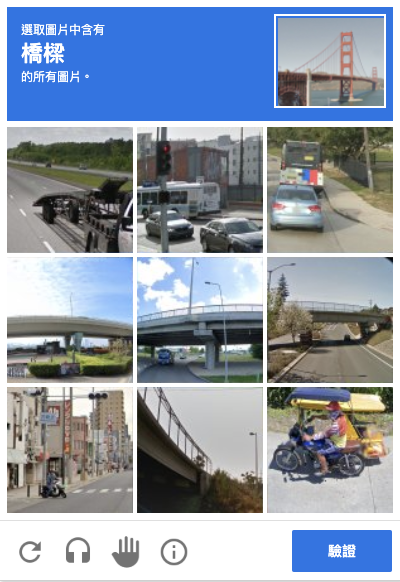

In [73]:
from PIL import Image
Image.open('ocr.png')

In [62]:
! open . 

In [1]:
API_KEY = '<GET YOUR KEY>'

In [63]:
# ---------- 3. 用Gemini 辨識圖片 ----------
PROMPT = '''
Given a CAPTCHA image displaying a grid, identify all images 
that contain the requested item as per the instruction. 
Return a JSON array of the 0-indexed positions of these images.
'''

def ask_gemini_for_indexes(png_path):
    api_key = API_KEY

    client = genai.Client(api_key=api_key)

    with open(png_path, "rb") as f:
        img_bytes = f.read()

    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_bytes(mime_type="image/png", data=img_bytes),
                types.Part.from_text(text = PROMPT),
            ],
        ),
    ]

    cfg = types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=-1),
        response_mime_type="application/json",
    )

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=contents,
        config=cfg,
    )

    return json.loads(response.text)

In [74]:
indexes = ask_gemini_for_indexes('ocr.png')
indexes

[3, 4, 5, 7]

In [65]:
# ---------- 4. 根據 indexes 點擊 bframe 內對應格子 ----------
def click_tiles_by_indexes(driver, wait, indexes):
    """
    根據 indexes 點擊 bframe 內對應格子
    """

    tiles = wait.until(EC.presence_of_all_elements_located(
        (By.CSS_SELECTOR, '[role="button"].rc-imageselect-tile')
    ))

    for idx in indexes:
        if 0 <= idx < len(tiles):
            tiles[idx].click()
            print(f"✅ 已點擊格子 {idx}")
        else:
            print(f"⚠️  索引 {idx} 超出範圍")


In [75]:
click_tiles_by_indexes(driver, wait, indexes)

✅ 已點擊格子 3
✅ 已點擊格子 4
✅ 已點擊格子 5
✅ 已點擊格子 7


In [76]:
# ---------- 5. 在 bframe 內點擊『驗證』. ----------
def click_verify_button(driver, wait):
    """在 bframe 內點擊『驗證』."""
    # 此時仍在 bframe；若已切回主頁請先 switch_to.frame(bframe)
    verify_btn = wait.until(
        EC.element_to_be_clickable((By.ID, "recaptcha-verify-button"))
    )
    verify_btn.click()
    print("✅ 已點擊『驗證』按鈕")
    driver.switch_to.default_content()

In [77]:
click_verify_button(driver, wait)

✅ 已點擊『驗證』按鈕
